In [13]:
import torch
import torch.nn as nn
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt


In [14]:
# ==========================================
# 1. Génération des données expérimentales
# ==========================================
def lorenz_system(t, state, sigma=10.0, rho=28.0, beta=8.0/3.0):
    x, y, z = state
    dx_dt = sigma * (y - x)
    dy_dt = x * (rho - z) - y
    dz_dt = x * y - beta * z
    return [dx_dt, dy_dt, dz_dt]

# Paramètres de simulation
dt = 0.01
t_end = 3.0
t_eval = np.arange(0, t_end, dt)
initial_state = [-8.0, 7.0, 27.0]

# Résolution numérique (Vérité terrain)
solution = solve_ivp(lorenz_system, [0, t_end], initial_state, t_eval=t_eval, method='RK45', rtol=1e-10, atol=1e-10)
t_data = solution.t.reshape(-1, 1)
X_data = solution.y.T  # (N, 3)

# --- NORMALISATION DES DONNÉES ---
# Normaliser le temps à [0, 1]
t_min, t_max = t_data.min(), t_data.max()
t_norm = (t_data - t_min) / (t_max - t_min)

# Normaliser les états (moyenne=0, std=1)
X_mean = X_data.mean(axis=0, keepdims=True)
X_std = X_data.std(axis=0, keepdims=True)
X_norm = (X_data - X_mean) / X_std

# Facteur d'échelle temporel pour corriger les dérivées : d(X_norm)/d(t_norm) = (t_max-t_min)/X_std * dX/dt
time_scale = (t_max - t_min)  # dt_norm = dt / time_scale

# Conversion en tenseurs PyTorch
t_tensor = torch.tensor(t_norm, dtype=torch.float32)
X_tensor = torch.tensor(X_norm, dtype=torch.float32)
X_mean_t = torch.tensor(X_mean, dtype=torch.float32)
X_std_t = torch.tensor(X_std, dtype=torch.float32)

In [15]:
# ==========================================
# 2. Définition de l'architecture du PINN
# ==========================================
class LorenzPINN(nn.Module):
    def __init__(self):
        super(LorenzPINN, self).__init__()
        
        # Réseau de neurones : t_norm -> [X_norm, Y_norm, Z_norm]
        hidden = 128
        self.net = nn.Sequential(
            nn.Linear(1, hidden),
            nn.Tanh(),
            nn.Linear(hidden, hidden),
            nn.Tanh(),
            nn.Linear(hidden, hidden),
            nn.Tanh(),
            nn.Linear(hidden, hidden),
            nn.Tanh(),
            nn.Linear(hidden, 3)
        )
        
        # Initialisation Xavier
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)
        
        # Paramètres physiques à découvrir
        self.log_sigma = nn.Parameter(torch.tensor(np.log(8.0)))  # ~8
        self.log_rho   = nn.Parameter(torch.tensor(np.log(20.0))) # ~20
        self.log_beta  = nn.Parameter(torch.tensor(np.log(2.0)))  # ~2
    
    @property
    def sigma(self):
        return torch.exp(self.log_sigma)
    
    @property
    def rho(self):
        return torch.exp(self.log_rho)
    
    @property
    def beta(self):
        return torch.exp(self.log_beta)

    def forward(self, t):
        return self.net(t)

    def physics_residuals(self, t, X_mean, X_std, time_scale):
        """Calcule les résidus physiques des 3 équations de Lorenz."""
        t = t.clone().detach().requires_grad_(True)
        X_pred_norm = self.forward(t)
        
        # Dé-normaliser
        x = X_pred_norm[:, 0:1] * X_std[0, 0] + X_mean[0, 0]
        y = X_pred_norm[:, 1:2] * X_std[0, 1] + X_mean[0, 1]
        z = X_pred_norm[:, 2:3] * X_std[0, 2] + X_mean[0, 2]
        
        # Dérivées : d(X_real)/dt_real = d(X_real)/dt_norm / time_scale
        dx = torch.autograd.grad(x, t, torch.ones_like(x), create_graph=True)[0] / time_scale
        dy = torch.autograd.grad(y, t, torch.ones_like(y), create_graph=True)[0] / time_scale
        dz = torch.autograd.grad(z, t, torch.ones_like(z), create_graph=True)[0] / time_scale
        
        # Résidus de Lorenz
        f_x = dx - self.sigma * (y - x)
        f_y = dy - (x * (self.rho - z) - y)
        f_z = dz - (x * y - self.beta * z)
        
        return f_x, f_y, f_z, X_pred_norm

model = LorenzPINN()
print(f"Paramètres initiaux : σ={model.sigma.item():.2f}, ρ={model.rho.item():.2f}, β={model.beta.item():.2f}")
print(f"Nombre de paramètres réseau : {sum(p.numel() for p in model.net.parameters())}")

Paramètres initiaux : σ=8.00, ρ=20.00, β=2.00
Nombre de paramètres réseau : 50179


In [ ]:
# ==========================================
# 3. Boucle d'entraînement
# ==========================================

# ---- PHASE 1 : Pré-entraînement pur données (ESSENTIEL) ----
# Le réseau doit d'abord bien approximer la trajectoire.
# Sans ça, la physics loss pousse vers la solution triviale (dérivées = 0).
print("=" * 60)
print("PHASE 1 : Pré-entraînement sur les données (sans physique)")
print("=" * 60)

optimizer_pre = torch.optim.Adam(model.net.parameters(), lr=1e-3)
scheduler_pre = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_pre, T_max=5000, eta_min=1e-5)

for epoch in range(5000):
    optimizer_pre.zero_grad()
    X_pred = model(t_tensor)
    loss = torch.mean((X_pred - X_tensor)**2)
    loss.backward()
    optimizer_pre.step()
    scheduler_pre.step()
    if epoch % 1000 == 0:
        print(f"  Epoch {epoch:5d} | Data Loss: {loss.item():.6f}")

print(f"  Epoch final | Data Loss: {loss.item():.6f}")
print()

# ---- PHASE 2 : Entraînement PINN (données + physique progressive) ----
print("=" * 60)
print("PHASE 2 : Entraînement avec physique (curriculum)")
print("=" * 60)

epochs = 10000

# Optimiseurs séparés
optimizer_nn = torch.optim.Adam(model.net.parameters(), lr=5e-4)
optimizer_phys = torch.optim.Adam(
    [model.log_sigma, model.log_rho, model.log_beta], lr=5e-3
)
scheduler_nn = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_nn, T_max=epochs, eta_min=1e-6)
scheduler_phys = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_phys, T_max=epochs, eta_min=5e-4)

# Lambda physique : démarre TRÈS bas, monte exponentiellement
# Ceci empêche la physics loss d'écraser la data loss au début
lambda_phys_min = 1e-4
lambda_phys_max = 1.0
lambda_ic = 5.0

# Historiques
epoch_hist = []
loss_data_hist = []
loss_phys_hist = []
loss_total_hist = []
sigma_hist = []
rho_hist = []
beta_hist = []

# Snapshots pour visu 3D
snapshot_epochs = [1000, 2000, 3000, 5000, 10000]
snapshots = {}

for epoch in range(epochs):
    epoch_num = epoch + 1
    optimizer_nn.zero_grad()
    optimizer_phys.zero_grad()
    
    # Montée exponentielle de lambda_phys sur 80% des epochs
    progress = min(epoch / (epochs * 0.8), 1.0)
    log_lambda = np.log(lambda_phys_min) + (np.log(lambda_phys_max) - np.log(lambda_phys_min)) * progress
    lambda_phys = np.exp(log_lambda)
    
    # Data loss
    t_req = t_tensor.clone().detach().requires_grad_(True)
    X_pred_norm = model(t_req)
    loss_data = torch.mean((X_pred_norm - X_tensor)**2)
    
    # Physics loss
    f_x, f_y, f_z, _ = model.physics_residuals(t_tensor, X_mean_t, X_std_t, time_scale)
    loss_physics = torch.mean(f_x**2) + torch.mean(f_y**2) + torch.mean(f_z**2)
    
    # IC loss - condition initiale
    X0 = model(t_tensor[0:1])
    x0 = X0[:, 0:1] * X_std_t[0, 0] + X_mean_t[0, 0]
    y0 = X0[:, 1:2] * X_std_t[0, 1] + X_mean_t[0, 1]
    z0 = X0[:, 2:3] * X_std_t[0, 2] + X_mean_t[0, 2]
    loss_ic = ((x0 - (-8.0))**2 + (y0 - 7.0)**2 + (z0 - 27.0)**2).mean()
    
    loss = loss_data + lambda_phys * loss_physics + lambda_ic * loss_ic
    loss.backward()
    
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
    
    optimizer_nn.step()
    optimizer_phys.step()
    scheduler_nn.step()
    scheduler_phys.step()
    
    # Historiques
    epoch_hist.append(epoch_num)
    loss_data_hist.append(loss_data.item())
    loss_phys_hist.append(loss_physics.item())
    loss_total_hist.append(loss.item())
    sigma_hist.append(model.sigma.item())
    rho_hist.append(model.rho.item())
    beta_hist.append(model.beta.item())
    
    if epoch_num in snapshot_epochs:
        with torch.no_grad():
            snap = model(t_tensor).detach().cpu().numpy()
            snapshots[epoch_num] = snap * X_std + X_mean
    
    if epoch % 1000 == 0:
        print(f"  Epoch {epoch:5d} | Loss: {loss.item():.4f} | Data: {loss_data.item():.6f} | "
              f"Phys: {loss_physics.item():.2f} | λp: {lambda_phys:.5f} | "
              f"σ={model.sigma.item():.2f} ρ={model.rho.item():.2f} β={model.beta.item():.2f}")

# # ---- PHASE 3 : Affinage L-BFGS ----
# print()
# print("=" * 60)
# print("PHASE 3 : Affinage L-BFGS")
# print("=" * 60)

# lbfgs = torch.optim.LBFGS(model.parameters(), lr=0.05, max_iter=20, history_size=100,
#                           line_search_fn='strong_wolfe')
# lambda_final = lambda_phys_max

# for i in range(200):
#     def closure():
#         lbfgs.zero_grad()
#         Xp = model(t_tensor)
#         ld = torch.mean((Xp - X_tensor)**2)
#         fx, fy, fz, _ = model.physics_residuals(t_tensor, X_mean_t, X_std_t, time_scale)
#         lp = torch.mean(fx**2) + torch.mean(fy**2) + torch.mean(fz**2)
#         X0 = model(t_tensor[0:1])
#         x0 = X0[:, 0:1] * X_std_t[0, 0] + X_mean_t[0, 0]
#         y0 = X0[:, 1:2] * X_std_t[0, 1] + X_mean_t[0, 1]
#         z0 = X0[:, 2:3] * X_std_t[0, 2] + X_mean_t[0, 2]
#         lic = ((x0 - (-8.0))**2 + (y0 - 7.0)**2 + (z0 - 27.0)**2).mean()
#         loss = ld + lambda_final * lp + lambda_ic * lic
#         loss.backward()
#         return loss
#     lbfgs.step(closure)
#     if i % 50 == 0:
#         print(f"  L-BFGS iter {i:3d} | σ={model.sigma.item():.3f} ρ={model.rho.item():.3f} β={model.beta.item():.3f}")

print()
print("=" * 60)
print(f"Vérité terrain : σ=10.00, ρ=28.00, β=2.67")
print(f"Estimations   : σ={model.sigma.item():.3f}, ρ={model.rho.item():.3f}, β={model.beta.item():.3f}")
err_s = abs(model.sigma.item() - 10.0) / 10.0 * 100
err_r = abs(model.rho.item() - 28.0) / 28.0 * 100
err_b = abs(model.beta.item() - 8/3) / (8/3) * 100
print(f"Erreurs       : σ={err_s:.1f}%, ρ={err_r:.1f}%, β={err_b:.1f}%")
print("=" * 60)

PHASE 1 : Pré-entraînement sur les données (sans physique)
  Epoch     0 | Data Loss: 1.007404
  Epoch  1000 | Data Loss: 0.000211
  Epoch  2000 | Data Loss: 0.000037
  Epoch  3000 | Data Loss: 0.000018
  Epoch  4000 | Data Loss: 0.000013
  Epoch final | Data Loss: 0.000012

PHASE 2 : Entraînement avec physique (curriculum)
  Epoch     0 | Loss: 1.0271 | Data: 0.000012 | Phys: 4404.39 | λp: 0.00010 | σ=8.04 ρ=20.10 β=2.01
  Epoch  2000 | Loss: 0.3088 | Data: 0.003618 | Phys: 20.91 | λp: 0.00100 | σ=8.59 ρ=27.98 β=2.49


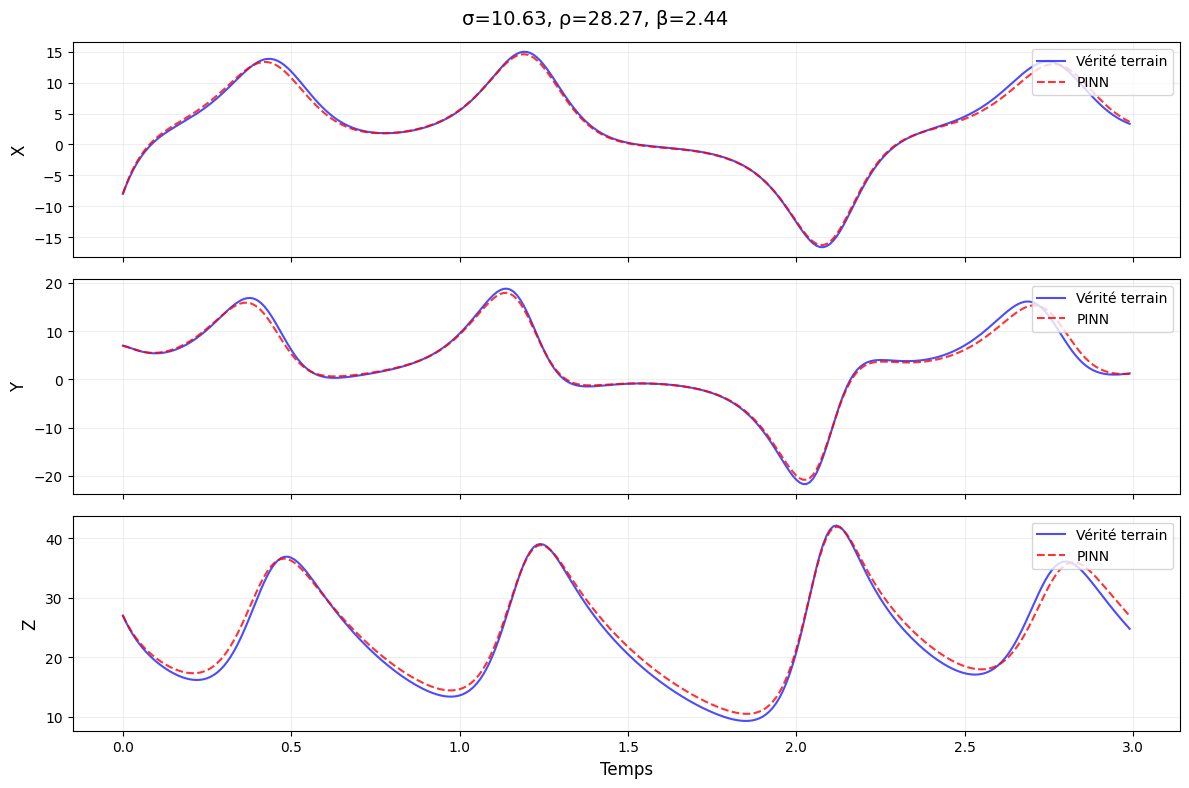

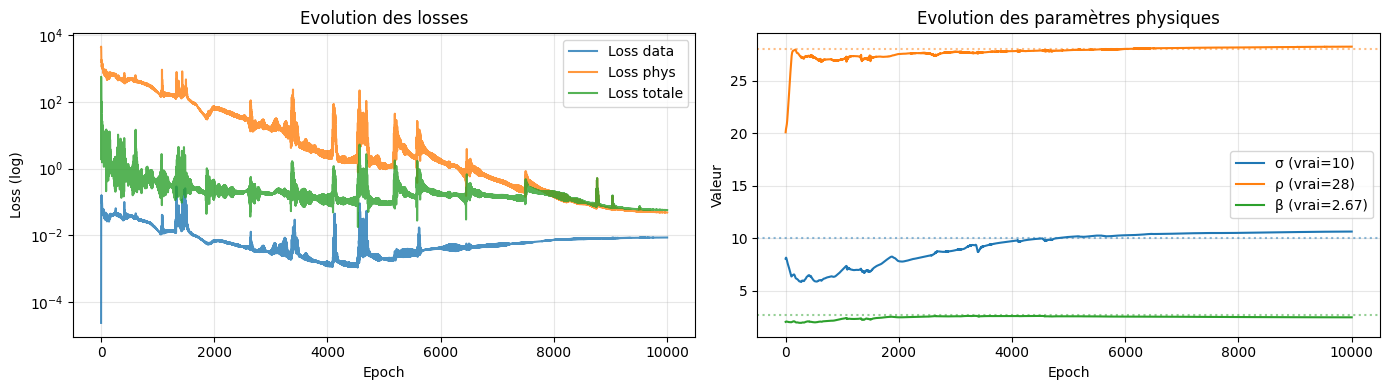

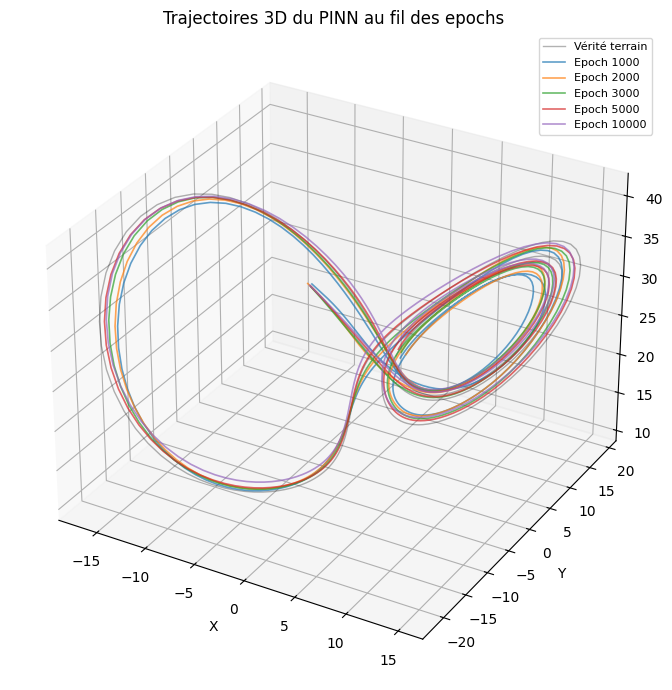

In [ ]:
# ==========================================
# 4. Visualisation
# ==========================================
with torch.no_grad():
    X_pred_norm = model(t_tensor).numpy()
    X_pred = X_pred_norm * X_std + X_mean

# --- Trajectoires X, Y, Z ---
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
labels = ['X', 'Y', 'Z']
for i in range(3):
    axes[i].plot(t_data, X_data[:, i], 'b-', label='Vérité terrain', alpha=0.7, lw=1.5)
    axes[i].plot(t_data, X_pred[:, i], 'r--', label='PINN', alpha=0.8, lw=1.5)
    axes[i].set_ylabel(labels[i], fontsize=12)
    axes[i].legend(loc='upper right')
    axes[i].grid(True, alpha=0.2)
axes[2].set_xlabel('Temps', fontsize=12)
fig.suptitle(f'σ={model.sigma.item():.2f}, ρ={model.rho.item():.2f}, β={model.beta.item():.2f}', fontsize=14)
plt.tight_layout()
plt.show()

# --- Evolution des losses (log scale) ---
if len(epoch_hist) > 0:
    fig_loss, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
    
    ax1.semilogy(epoch_hist, loss_data_hist, label='Loss data', alpha=0.8)
    ax1.semilogy(epoch_hist, loss_phys_hist, label='Loss phys', alpha=0.8)
    ax1.semilogy(epoch_hist, loss_total_hist, label='Loss totale', alpha=0.8)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss (log)')
    ax1.set_title('Evolution des losses')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Evolution des paramètres
    ax2.plot(epoch_hist, sigma_hist, label=f'σ (vrai=10)', lw=1.5)
    ax2.plot(epoch_hist, rho_hist, label=f'ρ (vrai=28)', lw=1.5)
    ax2.plot(epoch_hist, beta_hist, label=f'β (vrai=2.67)', lw=1.5)
    ax2.axhline(y=10.0, color='C0', ls=':', alpha=0.5)
    ax2.axhline(y=28.0, color='C1', ls=':', alpha=0.5)
    ax2.axhline(y=8/3, color='C2', ls=':', alpha=0.5)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Valeur')
    ax2.set_title('Evolution des paramètres physiques')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# --- Trajectoires 3D à différentes époques ---
if len(snapshots) > 0:
    fig3d = plt.figure(figsize=(10, 7))
    ax3d = fig3d.add_subplot(111, projection='3d')
    # Vérité terrain en gris
    ax3d.plot(X_data[:, 0], X_data[:, 1], X_data[:, 2], 'k-', alpha=0.3, lw=1, label='Vérité terrain')
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
    for idx, ep in enumerate(sorted(snapshots.keys())):
        traj = snapshots[ep]
        ax3d.plot(traj[:, 0], traj[:, 1], traj[:, 2], color=colors[idx % len(colors)],
                  label=f'Epoch {ep}', alpha=0.7, lw=1.2)
    ax3d.set_xlabel('X')
    ax3d.set_ylabel('Y')
    ax3d.set_zlabel('Z')
    ax3d.set_title('Trajectoires 3D du PINN au fil des epochs')
    ax3d.legend(fontsize=8)
    plt.tight_layout()
    plt.show()